:::{admonition} Download
:class: important

Download this notebook: **{nb-download}`Steerable_Pyramid.ipynb`**!

:::

# Steerable Pyramid

This tutorial walks through the basic features of the torch implementation of the Steerable Pyramid included in `plenoptic`, {class}`SteerablePyramidFreq <plenoptic.simulate.canonical_computations.steerable_pyramid_freq.SteerablePyramidFreq>`, and as such describes some basic signal processing that may be useful when building models that process images. We use the steerable pyramid construction in the frequency domain, which provides perfect reconstruction (as long as the input has an even height and width, i.e., `256x256` not `255x255`) and allows for any number of orientation bands. For more details on steerable pyramids and how they are built, see the [pyrtools tutorial](inv:pyrtools:std:doc#tutorials/03_steerable_pyramids).

Here we will specifically focus on the specifics of the torch version and how it may be used in concert with other differentiable torch models.

In [11]:
import contextlib
import itertools
import os
import ipdb

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from torch import nn
from tqdm.auto import tqdm

import plenoptic as po
from plenoptic.simulate import SteerablePyramidFreq
from plenoptic.tools.data import to_numpy

# this notebook uses torchvision, which is an optional dependency.
# if this fails, install torchvision in your plenoptic environment
# and restart the notebook kernel.
try:
    import torchvision
except ModuleNotFoundError:
    raise ModuleNotFoundError(
        "optional dependency torchvision not found!"
        " please install it in your plenoptic environment "
        "and restart the notebook kernel"
    )
import torchvision.transforms as transforms

dtype = torch.float32

# handle for tensors (use GPU if possible)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# magic commands to auto-reload imported modules anytime they are changed on disk
%load_ext autoreload
%autoreload 2

# so that relative sizes of axes created by po.imshow and others look right
plt.rcParams["figure.dpi"] = 72

%matplotlib inline

plt.rcParams["animation.html"] = "html5"
# use single-threaded ffmpeg for animation writer
plt.rcParams["animation.writer"] = "ffmpeg"
plt.rcParams["animation.ffmpeg_args"] = ["-threads", "1"]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Introduction: Steerable Pyramid Wavelets

In this section we will:

1. Visualize the wavelets that produce steerable pyramid coefficients
2. Visualize the steerable pyramid decomposition for two example images
3. Provide some technical details about this steerable pyramid implementation and how it may differ from others

### Visualizing Wavelets

Many modern computer vision algorithms employ convolution: a kernel slides across an image, taking inner products along the way. Thus the output of a convolution at a given location is the similarity between the kernel and the image content at that location, and therefore if your kernel has a low-spatial frequency it will function as a low-pass filter. Of course, low-pass filtering has a very simple interpretation in the fourier domain (simply attenuate the high spatial frequencies and leave low spatial frequencies unchanged). This particular scenario belies a more general fact: convolution in the spatial domain is mathematically equivalent to multiplication in the Fourier domain (a result known as the [convolution theorem](https://en.wikipedia.org/wiki/Convolution_theorem)). Though both are equivalent there may be advantages to carrying out the operation in one domain or the other. This implementation of the steerable pyramid operates in the Fourier domain. For those that are interested, the first benefit of this implementation is that we have access to a perfectly invertible representation (i.e. the representation can be inverted to reconstruct the input perfectly and therefore, one can analyze how perturbations to the representation are visualized in the input space). Second, working in the Fourier domain, allows us to work with a complex-valued representation which can provide natural benefits like being able to construct quadrature pair filters etc. easily.

Because of this we don't have direct access to a set of spatial filters for visualization, however we can generate the equivalent spatial filters by inverting a set of coefficients (i.e., output of the pyramid) constructed to contain zero everywhere *except in the center of a single band*. Below we do this to visualize the filters for a 3 scale 4 orientation steerable pyramid.

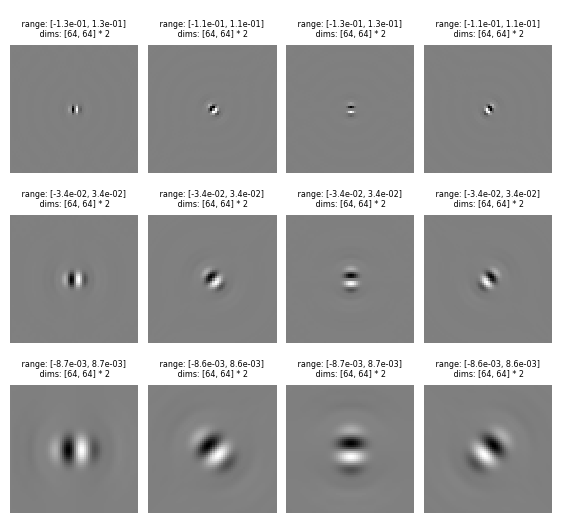

In [12]:
# Visualizing the filters of the steerable pyramid (these are in fourier domain)
# so using the trick described above

order = 3     # this will result in order+1 (orientation)
numScales = 3 # this is only bandpass; excludes the highpass and lowpass
imsize = 64

# build a steerable pyramid object
pyr = SteerablePyramidFreq(height=numScales, image_shape=[imsize, imsize], order=order).to(
    DEVICE
)
# decompose a blank image
empty_image = torch.zeros((1, 1, imsize, imsize), dtype=dtype).to(DEVICE)
pyr_coeffs = pyr(empty_image)

# insert a 1 in the center of each coefficient...
# unit impulse in coefficient space
for k, v in pyr.pyr_size.items():
    mid = (v[0] // 2, v[1] // 2)
    pyr_coeffs[k][..., mid[0], mid[1]] = 1

# ... and then reconstruct this dummy image for each impulse to visualize the filter.
reconList = []
for scale, ori in itertools.product(range(pyr.num_scales), range(pyr.num_orientations)):
    reconList.append(pyr.recon_pyr(pyr_coeffs, [scale], [ori]))

# these are the spatial impulse response functions (filter kernel for SF and ori)
po.imshow(reconList, col_wrap=order + 1, vrange="indep1", zoom=2);

We can see that this pyramid is representing a 3 scale 4 orientation decomposition: each row represents a single scale, which we can see because each filter is the same size. As the filter increases in size, we describe the scale as getting "coarser", and its spatial frequency selectivity moves to lower and lower frequencies (conversely, smaller filters are operating at finer scales, with selectivity to higher spatial frequencies). In a given column, all filters have the same orientation: the first column is vertical, the third horizontal, and the other two diagonals.

### Visualizing Filter Responses (Wavelet Coefficients)
Now let's see what the steerable pyramid representation for images look like.

The included steerable pyramid operates on 4-dimensional tensors of shape `(batch, channel, height, width)`. We are able to perform batch computations with the steerable pyramid implementation, analyzing each batch separately. Similarly, the pyramid is meant to operate on gray-scale images, and so `channel > 1` will cause the pyramid to run independently on each channel (meaning each of the first two dimensions are treated effectively as batch dimensions).

In [13]:
np.shape(po.data.curie())

torch.Size([1, 1, 256, 256])

torch.Size([2, 1, 256, 256])


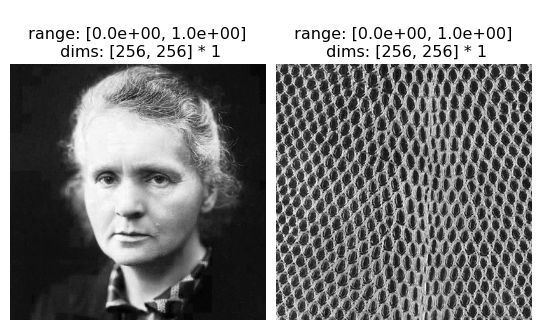

In [14]:
# image batch is stored as a Tensor
im_batch = torch.cat([po.data.curie(), po.data.reptile_skin()], axis=0).to(DEVICE)

# dim: 2 images, 1ch, xpix, ypix
print(im_batch.shape)
po.imshow(im_batch)

order = 3    # this will result in order+1 (orientation)
dim_im = 256

# build a steerable pyramid object
pyr = SteerablePyramidFreq(height=4, image_shape=[dim_im, dim_im], order=order).to(
    DEVICE
)

# pass the Tensor into the object
pyr_coeffs = pyr(im_batch)

By default, the output of the pyramid is stored as a dictionary whose keys are either a string for the `'residual_lowpass'` and `'residual_highpass'` bands or a tuple of `(scale_index, orientation_index)`. `plenoptic` provides a convenience function, {func}`pyrshow <plenoptic.tools.display.pyrshow>`, to visualize the pyramid's coefficients for each image and channel.

odict_keys(['residual_highpass', (0, 0), (0, 1), (0, 2), (0, 3), (1, 0), (1, 1), (1, 2), (1, 3), (2, 0), (2, 1), (2, 2), (2, 3), (3, 0), (3, 1), (3, 2), (3, 3), 'residual_lowpass'])


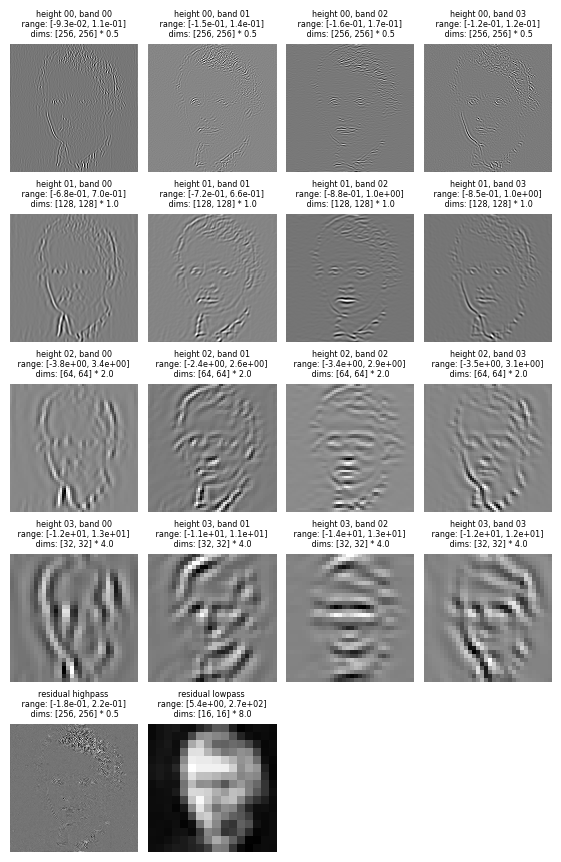

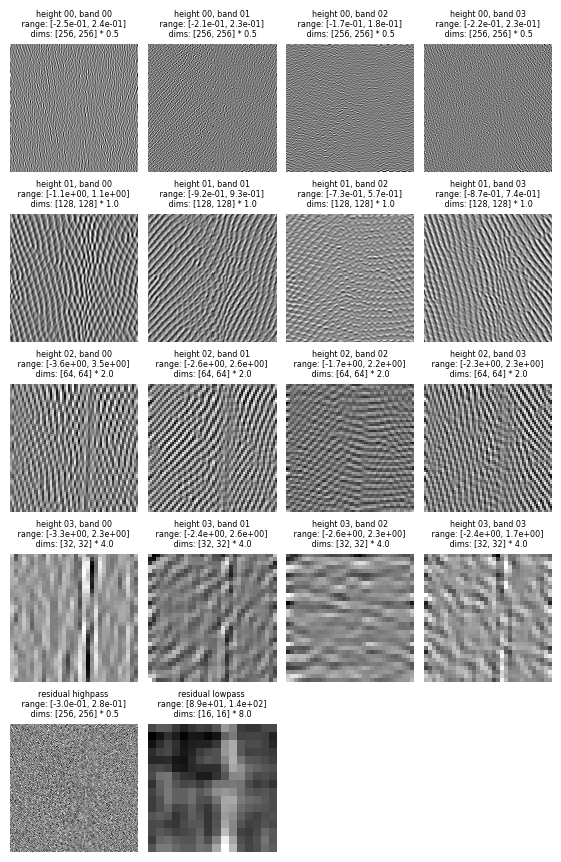

In [15]:
print(pyr_coeffs.keys())

# first image of the batch (Curie)
po.pyrshow(pyr_coeffs, zoom=0.5, batch_idx=0)

# second image of the batch (snake skin)
po.pyrshow(pyr_coeffs, zoom=0.5, batch_idx=1);

For some applications, such as coarse-to-fine optimization procedures, it may be convenient to output a subset of the representation, including coefficients from only some scales. We do this by passing a `scales` argument to the forward method (a list containing a subset of the values found in {attr}`pyr.scales <plenoptic.simulate.canonical_computations.steerable_pyramid_freq.SteerablePyramidFreq.scales>`):

['residual_lowpass', 3, 2, 1, 0, 'residual_highpass']


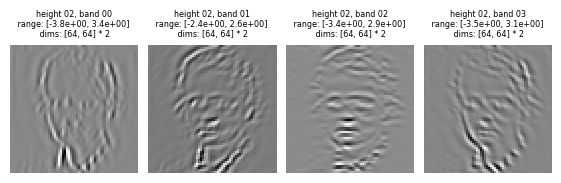

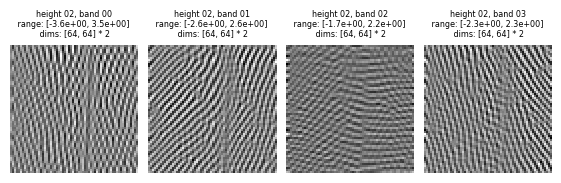

In [16]:
# get the 3rd SF scale
print(pyr.scales)
pyr_coeffs_scale0 = pyr(im_batch, scales=[2])
po.pyrshow(pyr_coeffs_scale0, zoom=2, batch_idx=0)
po.pyrshow(pyr_coeffs_scale0, zoom=2, batch_idx=1);

## THE COMPLEX PYRAMID

The above pyramid was the real pyramid but in many applications we might want the full complex pyramid output. This can be set using the `is_complex` argument. When `is_complex=True`, the pyramid uses a complex-valued filter, resulting in a complex-valued output. The real and imaginary components can be understood as the outputs of filters with identical scale and orientation, but different phases: the imaginary component is phase-shifted 90 degrees from the real (we refer to this matched pair of filters as a "quadrature pair"). This can be useful if you wish to construct a representation that is phase-insensitive (as complex cells in the primary visual cortex are believed to be), which can be done by computing the amplitude / complex modulus (e.g., call `torch.abs(x)`). {func}`rectangular_to_polar <plenoptic.tools.signal.rectangular_to_polar>` and {func}`rectangular_to_polar_dict <plenoptic.simulate.canonical_computations.non_linearities.rectangular_to_polar_dict>` provide convenience wrappers for this functionality.

In [17]:
order = 3
height = 3

pyr_complex = SteerablePyramidFreq(
    height=height, image_shape=[256, 256], order=order, is_complex=True).to(
    DEVICE
)

pyr_coeffs_complex = pyr_complex(im_batch)

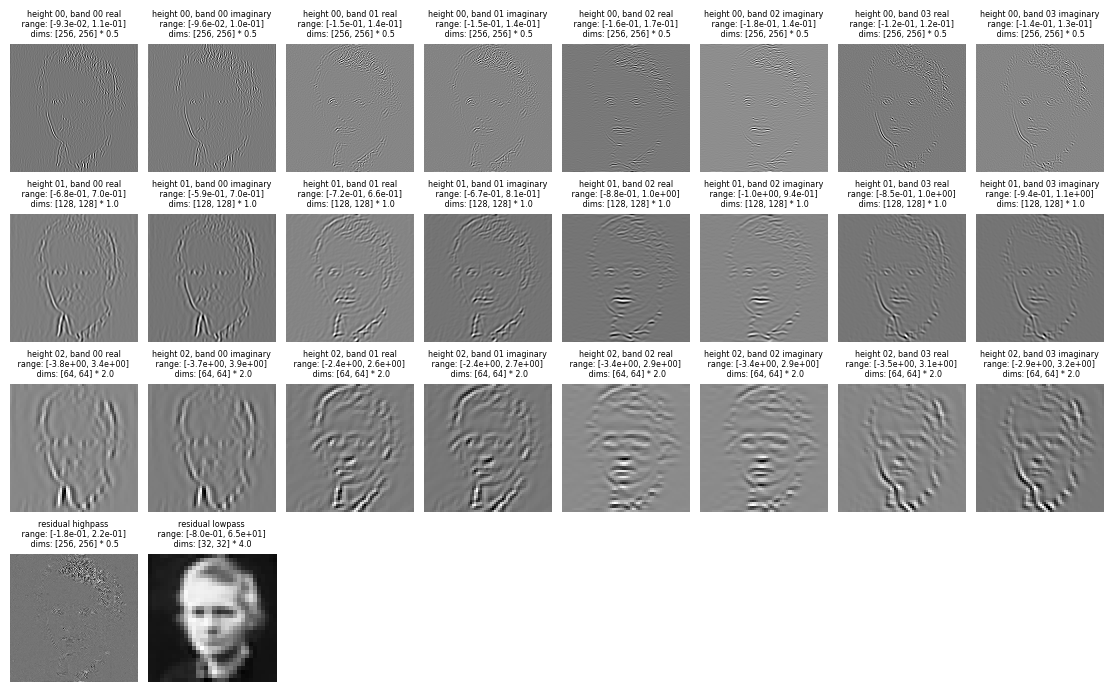

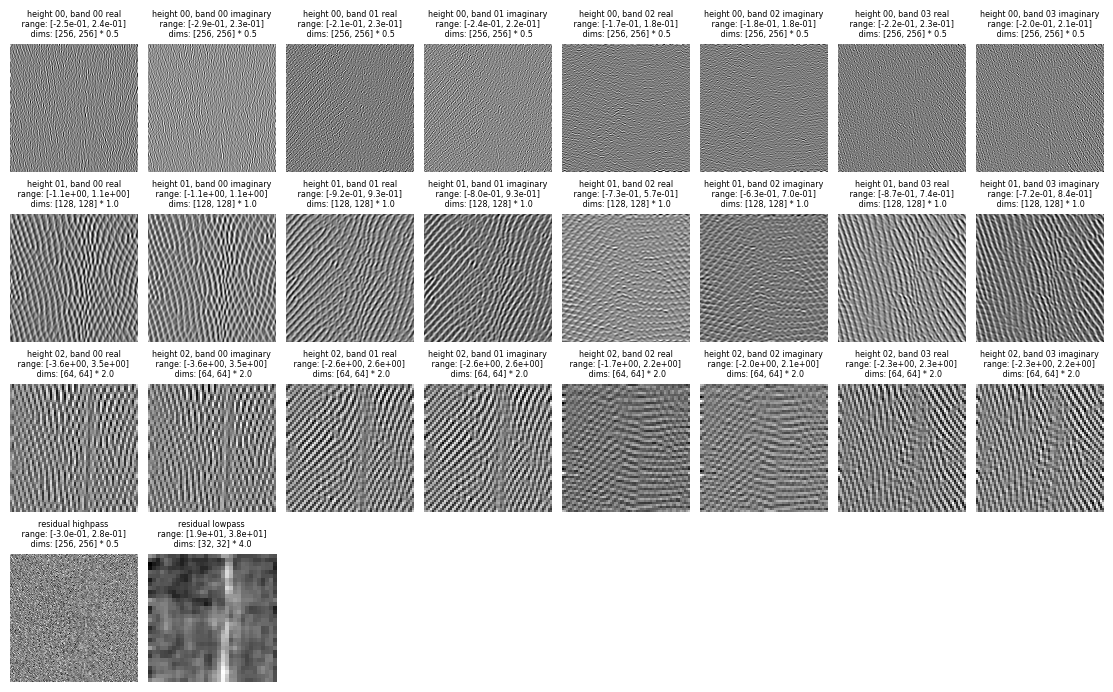

In [18]:
# the same visualization machinery works for complex pyramids what is shown is the
# magnitude of the coefficients
po.pyrshow(pyr_coeffs_complex, zoom=0.5, batch_idx=0)
po.pyrshow(pyr_coeffs_complex, zoom=0.5, batch_idx=1);

Now that we have seen the basics of using the pyramid, it's worth noting the following: an important property of the steerable pyramid is that it should respect the generalized parseval theorem (i.e. the energy of the pyramid coefficients should equal the energy of the original image). The [matlabpyrtools](https://github.com/LabForComputationalVision/matlabPyrTools) and [pyrtools](inv:pyrtools:std:doc#index) versions of the SteerablePyramid DO NOT respect this, so in our version, we have provided a fix that normalizes the FFTs such that energy is preserved. This is set using the `tight_frame=True` when instantiating the pyramid. However, if you require matching the outputs to the matlabPyrTools or PyrTools versions, please note that you will need to set this argument to `False`.

## Boundary handling

The steerable pyramid included in plenoptic operates in the frequency domain and thus can only use circular boundary-handling. If you would like, you can use [PyTorch's padding layers](https://pytorch.org/docs/stable/nn.html#padding-layers) to build a single plenoptic-compliant module that pads your input:

In [19]:
class PaddedSteerPyr(torch.nn.Module):
    def __init__(self, image_shape, padding_pixels=12, height="auto", order=3):
        super().__init__()
        self.pyr = SteerablePyramidFreq(
            [s + 2 * padding_pixels for s in image_shape], height=height, order=order
        )
        self.padder = torch.nn.ZeroPad2d(padding_pixels)

    def forward(self, x, scales=None):
        padded_x = self.padder(x)
        coeffs = self.pyr(padded_x)
        return coeffs

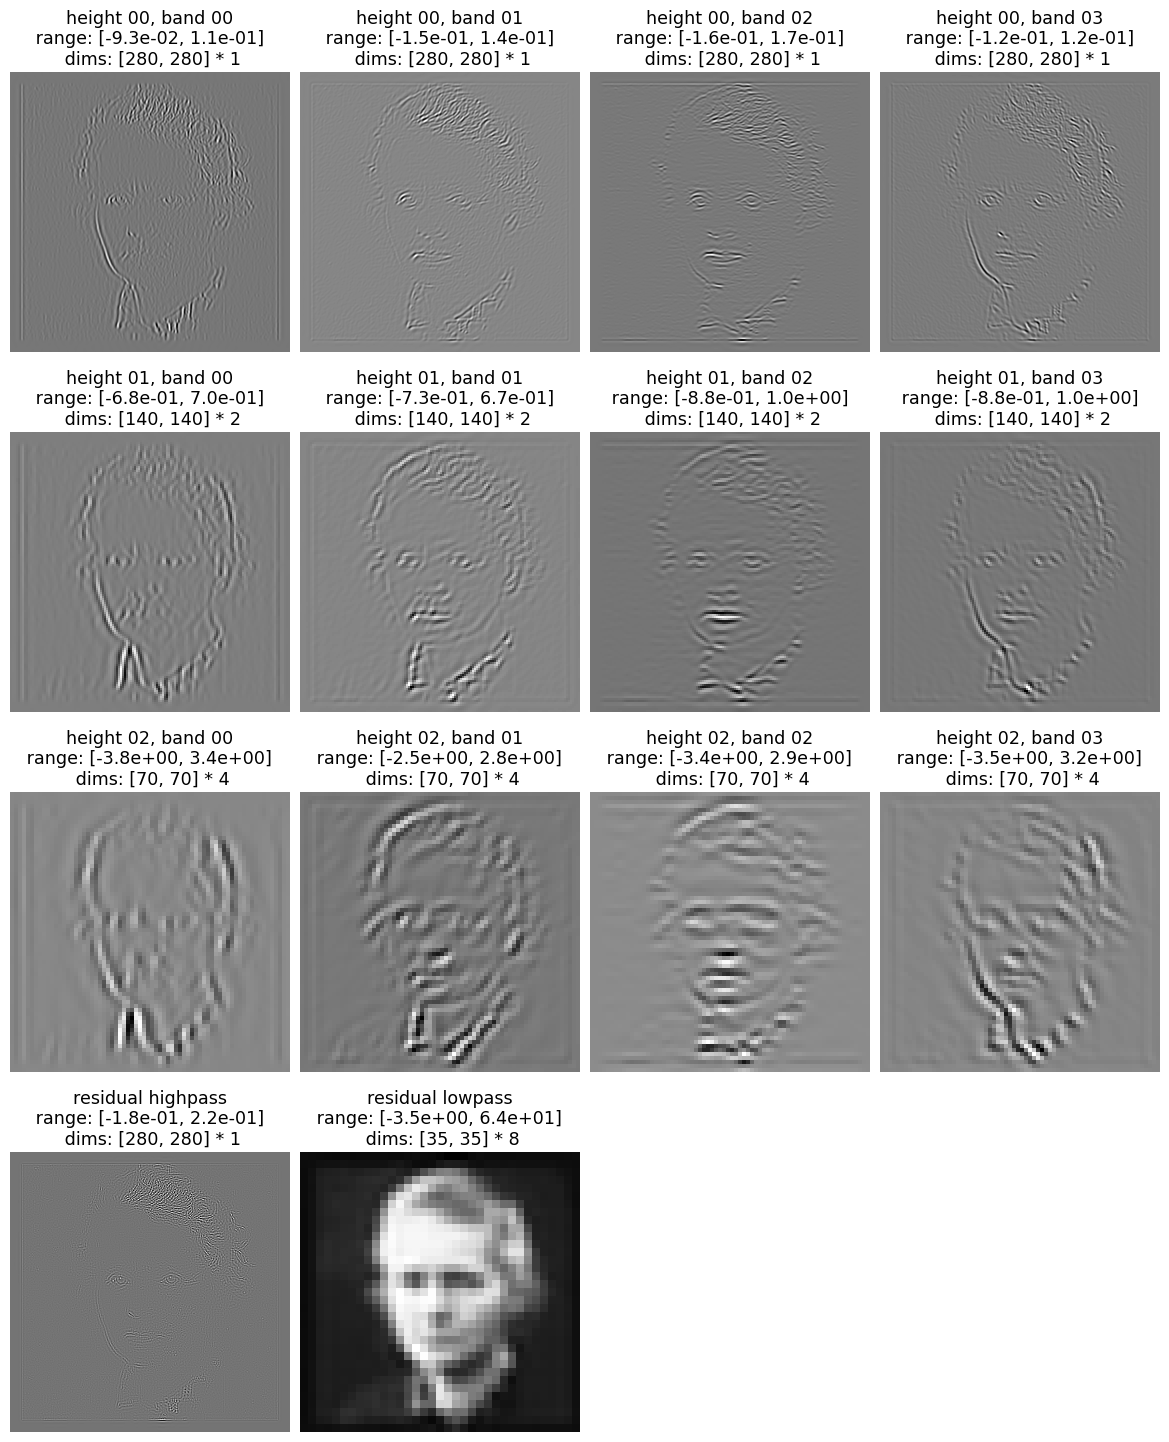

In [20]:
ppyr = PaddedSteerPyr(im_batch.shape[-2:], height=3).to(DEVICE)

ppyr_coeffs = ppyr(im_batch)
po.pyrshow(ppyr_coeffs);

You can see the boundary effect in the above coefficients, as a faint "frame". For that reason, you may want to make use of [Torchvision's CenterCrop module](https://pytorch.org/vision/master/generated/torchvision.transforms.CenterCrop.html) to build a similar module that pads your input and crops your output, so that the returned tensors are the same shape as they would be without padding:

In [21]:
class PaddedCroppedSteerPyr(torch.nn.Module):
    def __init__(self, image_shape, padding_pixels=10, height="auto", order=3):
        super().__init__()
        self.pyr = SteerablePyramidFreq(
            [s + 2 * padding_pixels for s in image_shape], height=height, order=order
        )
        self.padder = torch.nn.ZeroPad2d(padding_pixels)
        # keep track of what the shape would be without padding
        scale_shapes = [
            np.ceil((np.array(image_shape) - 0.5) / 2**i).astype(int)
            for i in range(self.pyr.num_scales)
        ]
        print(scale_shapes)

        # error is when excuting the following ############
        self.croppers = {
            i: torchvision.transforms.CenterCrop(s) for i, s in enumerate(scale_shapes)
        }
                ############
        
        self.croppers["residual_highpass"] = torchvision.transforms.CenterCrop(
            image_shape
        )
        lowpass_shape = np.ceil((scale_shapes[-1] - 0.5) / 2).astype(int)
        self.croppers["residual_lowpass"] = torchvision.transforms.CenterCrop(
            lowpass_shape
        )

    def forward(self, x, scales=None):
        padded_x = self.padder(x)
        coeffs = self.pyr(padded_x)
        to_return = {}
        for k, v in coeffs.items():
            if isinstance(k, str):
                to_return[k] = self.croppers[k](v) # original
            else:
                to_return[k] = self.croppers[k[0]](v) # RE: added this if statement
        return to_return

In [25]:
pcpyr

PaddedCroppedSteerPyr(
  (pyr): SteerablePyramidFreq()
  (padder): ZeroPad2d((10, 10, 10, 10))
)

[array([256, 256]), array([128, 128]), array([64, 64])]


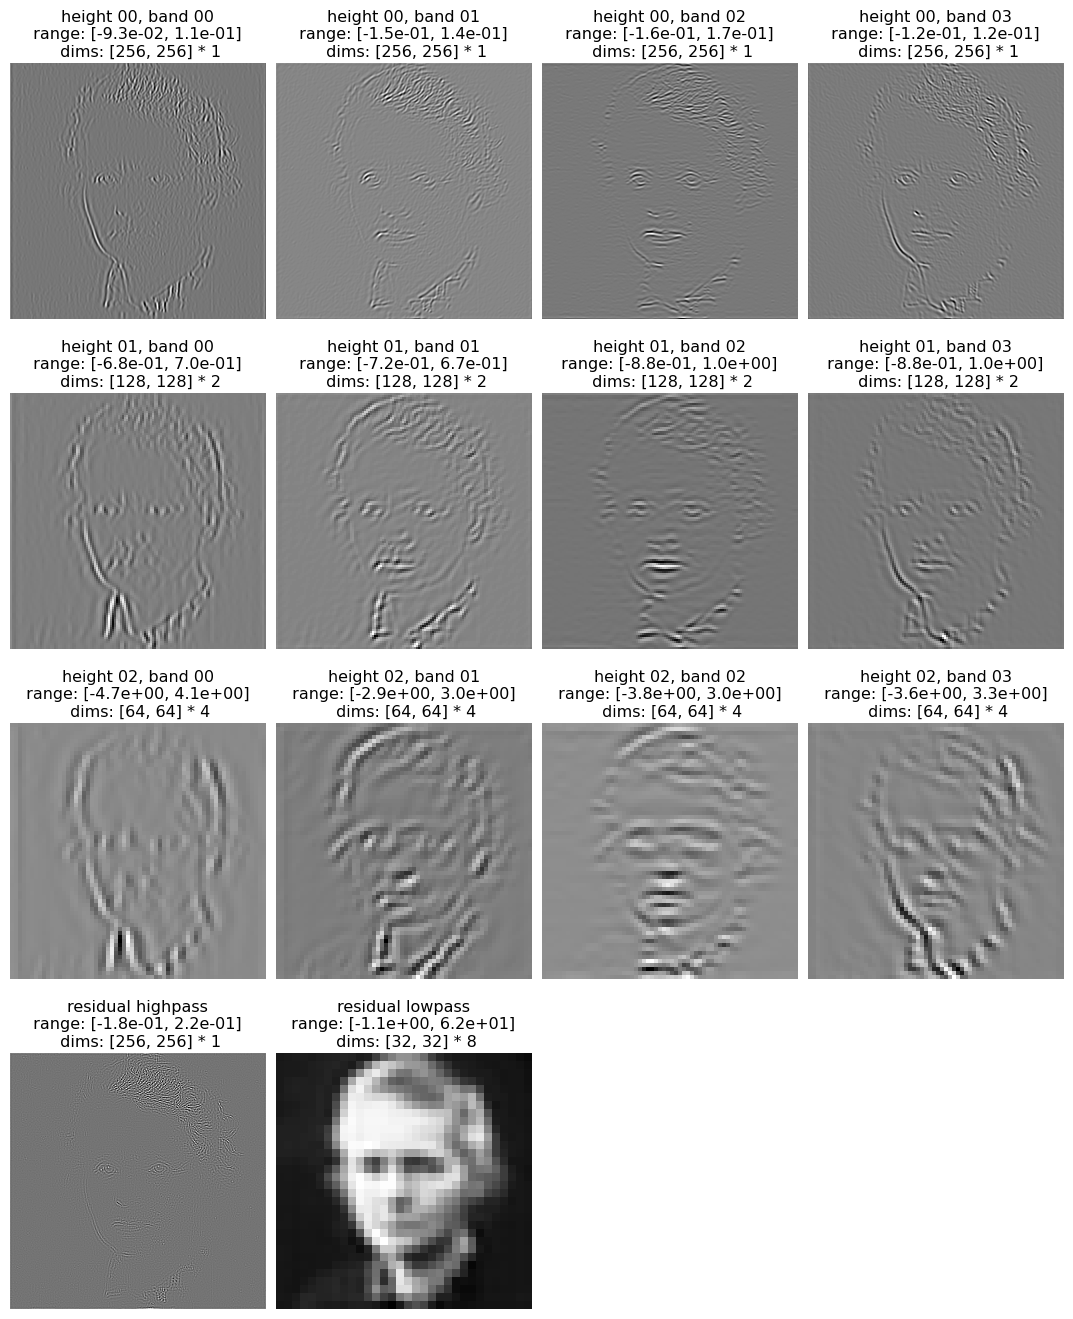

In [22]:

pcpyr = PaddedCroppedSteerPyr(im_batch.shape[-2:], height=3).to(DEVICE)

pyr = SteerablePyramidFreq(im_batch.shape[-2:], height=3).to(DEVICE)

# check that the coefficients are the same shape as when you have no padding
pcpyr_coeffs = pcpyr(im_batch)

for k, v in pyr(im_batch).items():
    assert v.shape == pcpyr_coeffs[k].shape
po.pyrshow(pcpyr_coeffs);

## STOPPED HERE

## Putting the "Steer" in Steerable Pyramid
As we have seen, steerable pyramids decompose images into a fixed set of orientation bands (at several spatial scales). However given the responses at this fixed set of orientation bands, the pyramid coefficients for any arbitrary intermediate orientation can be calculated from a linear interpolation of the original bands. This property is known as "steerability."

Below we steer a set of coefficients through a series of angles and visualize how the represented features rotate.

In [75]:
# note that steering is currently only implemented for real pyramids, so the is_complex
# argument must be False (as it is by default)
pyr = SteerablePyramidFreq(height=3, image_shape=[256, 256], order=3, twidth=1).to(
    DEVICE
)
coeffs = pyr(im_batch)

resteered_coeffs, _ = pyr.steer_coeffs(coeffs, torch.linspace(0, 2 * torch.pi, 64))
# play around with different scales! Coarser scales tend to make the steering a bit
# more obvious.
target_scale = 2
po.animshow(
    resteered_coeffs[target_scale], framerate=6, repeat=True, zoom=2**target_scale
)

KeyError: 2

## Example Application: Frontend for Convolutional Neural Network

Until now we have just seen how to use the Steerable Pyramid as a stand-alone fixed feature extractor, but what if we wanted to use it in a larger model, as a front-end for a deep CNN or other model? The steerable pyramid decomposition is qualitatively similar to the computations in primary visual cortex,  so it stands to reason that using a steerable pyramid frontend might serve as an inductive bias that encourages subsequent layers to have more biological structure. In the literature it has been demonstrated that using a V1-like front end attached to a CNN trained on classification can lead to improvements in adversarial robustness [Dapello et. al, 2020](https://proceedings.neurips.cc/paper/2020/hash/98b17f068d5d9b7668e19fb8ae470841-Abstract.html).

In this section we will demonstrate how the plenoptic steerable pyramid can be made compatible with standard deep learning architectures and use it as a frontend for a standard CNN.

### Preliminaries

Most standard model architectures only accept channels with fixed shape, but each scale of the pyramid coefficients has a different shape (because each scale is downsampled by a factor of 2). In order to obtain an output amenable to downstream processing by standard torch modules, we have created an argument to the pyramid (`downsample=False`) that does not downsample the frequency masks at each scale and thus maintains output feature maps that all have a fixed size. Once you have done this, you can then convert the dictionary into a tensor of size `(batch, channel, height, width)` so that it can easily be passed to a downstream {class}`torch.nn.Module`. The details of how to do this are provided in the the {func}`convert_pyr_to_tensor <plenoptic.simulate.canonical_computations.steerable_pyramid_freq.SteerablePyramidFreq.convert_pyr_to_tensor>` function within the SteerablePyramidFreq class. Let's try this and look at the first image both in the downsampled and not downsampled versions:

In [ ]:
height = 3
order = 3
pyr_fixed = SteerablePyramidFreq(
    height=height,
    image_shape=[256, 256],
    order=order,
    is_complex=True,
    downsample=False,
    tight_frame=True,
).to(DEVICE)
pyr_coeffs_fixed, pyr_info = pyr_fixed.convert_pyr_to_tensor(pyr_fixed(im_batch))
# we can also split the complex coefficients into real and imaginary parts as
# separate channels.
pyr_coeffs_split, _ = pyr_fixed.convert_pyr_to_tensor(
    pyr_fixed(im_batch), split_complex=True
)
print(pyr_coeffs_split.shape, pyr_coeffs_split.dtype)
print(pyr_coeffs_fixed.shape, pyr_coeffs_fixed.dtype)

We can see that in this complex pyramid with 4 scales and 3 orientations there will be 26 channels: 4 scales x 3 orientations x 2 (for real and imaginary featuremaps) + 2 (for the residual bands).

In order to display the coefficients, we need to convert the tensor coefficients back to a dictionary. We can do this by using the {func}`convert_tensor_to_pyr <plenoptic.simulate.canonical_computations.steerable_pyramid_freq.SteerablePyramidFreq.convert_tensor_to_pyr>` method. We can check that these are equal.

In [ ]:
pyr_coeffs_fixed_1 = pyr_fixed(im_batch)
pyr_coeffs_fixed_2 = pyr_fixed.convert_tensor_to_pyr(pyr_coeffs_fixed, *pyr_info)
for k in pyr_coeffs_fixed_1:
    print(torch.allclose(pyr_coeffs_fixed_2[k], pyr_coeffs_fixed_1[k]))

True
True
True
True


We can now plot the coefficients for the not downsampled version (`pyr_coeffs_complex` from the last section) and the downsampled version `pyr_coeffs_fixed_1` from above and see how they compare visually.

In [ ]:
po.pyrshow(pyr_coeffs_complex, zoom=0.5)
po.pyrshow(pyr_coeffs_fixed_1, zoom=0.5);

We can see that the not downsampled version maintains the same features as the original pyramid, but with fixed feature maps that have spatial dimensions equal to the original image (256x256). However, the pixel magnitudes in the bands are different due to the fact that we are not downsampling in the frequency domain anymore. This can equivalently be thought of as the inverse operation of blurring and downsampling. Therefore the upsampled versions of each scale are not simply zero interpolated versions of the downsampled versions and thus the pixel values are non-trivially changed.
However, the energy in each band should be preserved between the two pyramids and we can check this by computing the energy in each band for the two pyramids and checking if they are the same.

In [ ]:
# the following passes with tight_frame=True or tight_frame=False, either way.
pyr_not_downsample = SteerablePyramidFreq(
    height=height,
    image_shape=[256, 256],
    order=order,
    is_complex=False,
    twidth=1,
    downsample=False,
    tight_frame=False,
)
pyr_not_downsample.to(DEVICE)

pyr_downsample = SteerablePyramidFreq(
    height=height,
    image_shape=[256, 256],
    order=order,
    is_complex=False,
    twidth=1,
    downsample=True,
    tight_frame=False,
)
pyr_downsample.to(DEVICE)
pyr_coeffs_downsample = pyr_downsample(im_batch.to(DEVICE))
pyr_coeffs_not_downsample = pyr_not_downsample(im_batch.to(DEVICE))
for i in range(len(pyr_coeffs_downsample.keys())):
    k = list(pyr_coeffs_downsample.keys())[i]
    v1 = to_numpy(pyr_coeffs_downsample[k])
    v2 = to_numpy(pyr_coeffs_not_downsample[k])
    v1 = v1.squeeze()
    v2 = v2.squeeze()
    # check if energies match in each band between downsampled and fixed size pyramid
    # responses
    print(
        np.allclose(
            np.sum(np.abs(v1) ** 2),
            np.sum(np.abs(v2) ** 2),
            rtol=1e-4,
            atol=1e-4,
        )
    )

## Model Training
We are now ready to demonstrate how the steerable pyramid can be used as a fixed frontend for further stages of (learnable) processing!

In [ ]:
# First we define/download the dataset. The with block here effectively suppresses
# stderr, so we don't print out the progressbar. If you would like to see it, remove
# this line.
with contextlib.redirect_stderr(open(os.devnull, "w")):
    train_set = torchvision.datasets.FashionMNIST(
        # change this line to wherever you'd like to download the FashionMNIST dataset
        root="../data",
        train=True,
        download=True,
        transform=transforms.Compose([transforms.ToTensor()]),
    )

We will define a simple model, which consists of the steerable pyramid, followed by a single convolutional layer, then a single fully connected layer.

In [ ]:
class PyrConvFull(nn.Module):
    def __init__(self, imshape, order, scales, exclude=[], is_complex=True):
        super().__init__()

        self.imshape = imshape
        self.order = order
        self.scales = scales
        self.output_dim = 20  # number of channels in the convolutional block
        self.kernel_size = 6
        self.is_complex = is_complex

        self.rect = nn.ReLU()
        self.pyr = SteerablePyramidFreq(
            height=self.scales,
            image_shape=self.imshape,
            order=self.order,
            is_complex=self.is_complex,
            twidth=1,
            downsample=False,
        )

        # num_channels = num_scales * num_orientations (+ 2  residual bands)
        # (* 2 if complex)
        channels_per = 2 if self.is_complex else 1
        self.pyr_channels = ((self.order + 1) * self.scales + 2) * channels_per

        self.conv = nn.Conv2d(
            in_channels=self.pyr_channels,
            kernel_size=self.kernel_size,
            out_channels=self.output_dim,
            stride=2,
        )
        # the input ndim here has to do with the dimensionality of self.conv's output,
        # so will have to change
        # if kernel_size or output_dim do
        self.fc = nn.Linear(self.output_dim * 12**2, 10)

    def forward(self, x):
        out = self.pyr(x)
        out, _ = self.pyr.convert_pyr_to_tensor(out)

        # case handling for real v. complex forward passes
        if self.is_complex:
            # split to real and imaginary so nonlinearities make sense
            out_re = self.rect(out.imag)
            out_im = self.rect(out.real)

            # concatenate
            out = torch.cat([out_re, out_im], dim=1)
        else:
            out = self.rect(out)

        out = self.conv(out)
        out = self.rect(out)
        out = out.view(out.shape[0], -1)  # reshape for linear layer
        out = self.fc(out)

        return out

Now, we train this model:

In [ ]:
# Training Pyramid Model
model_pyr = PyrConvFull([28, 28], order=4, scales=2, is_complex=False)
model_pyr.to(DEVICE)
loader = torch.utils.data.DataLoader(train_set, batch_size=50)
optimizer = torch.optim.Adam(model_pyr.parameters(), lr=1e-3)


epoch = 2
losses = []
fracts_correct = []
for e in range(epoch):
    for batch in tqdm(loader):
        images = batch[0].to(DEVICE)
        labels = batch[1].to(DEVICE)
        preds = model_pyr(images)
        loss = F.cross_entropy(preds, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

        n_correct = preds.argmax(dim=1).eq(labels).sum().item()
        fracts_correct.append(n_correct / 50)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].plot(losses)
axs[0].set_xlabel("Iteration")
axs[0].set_ylabel("Cross Entropy Loss")
axs[1].plot(fracts_correct)
axs[1].set_xlabel("Iteration")
axs[1].set_ylabel("Classification Performance");

The steerable pyramid can be smoothly integrated with standard torch modules and autograd, so the impact of including such a frontend could be probed using the synthesis techniques provided by Plenoptic.